    Cluster 01 (49 variables) correlation = 0.191
    Cluster 02 (36 variables) correlation = 0.229

--- Cluster 1 (Window size : 24h) ---


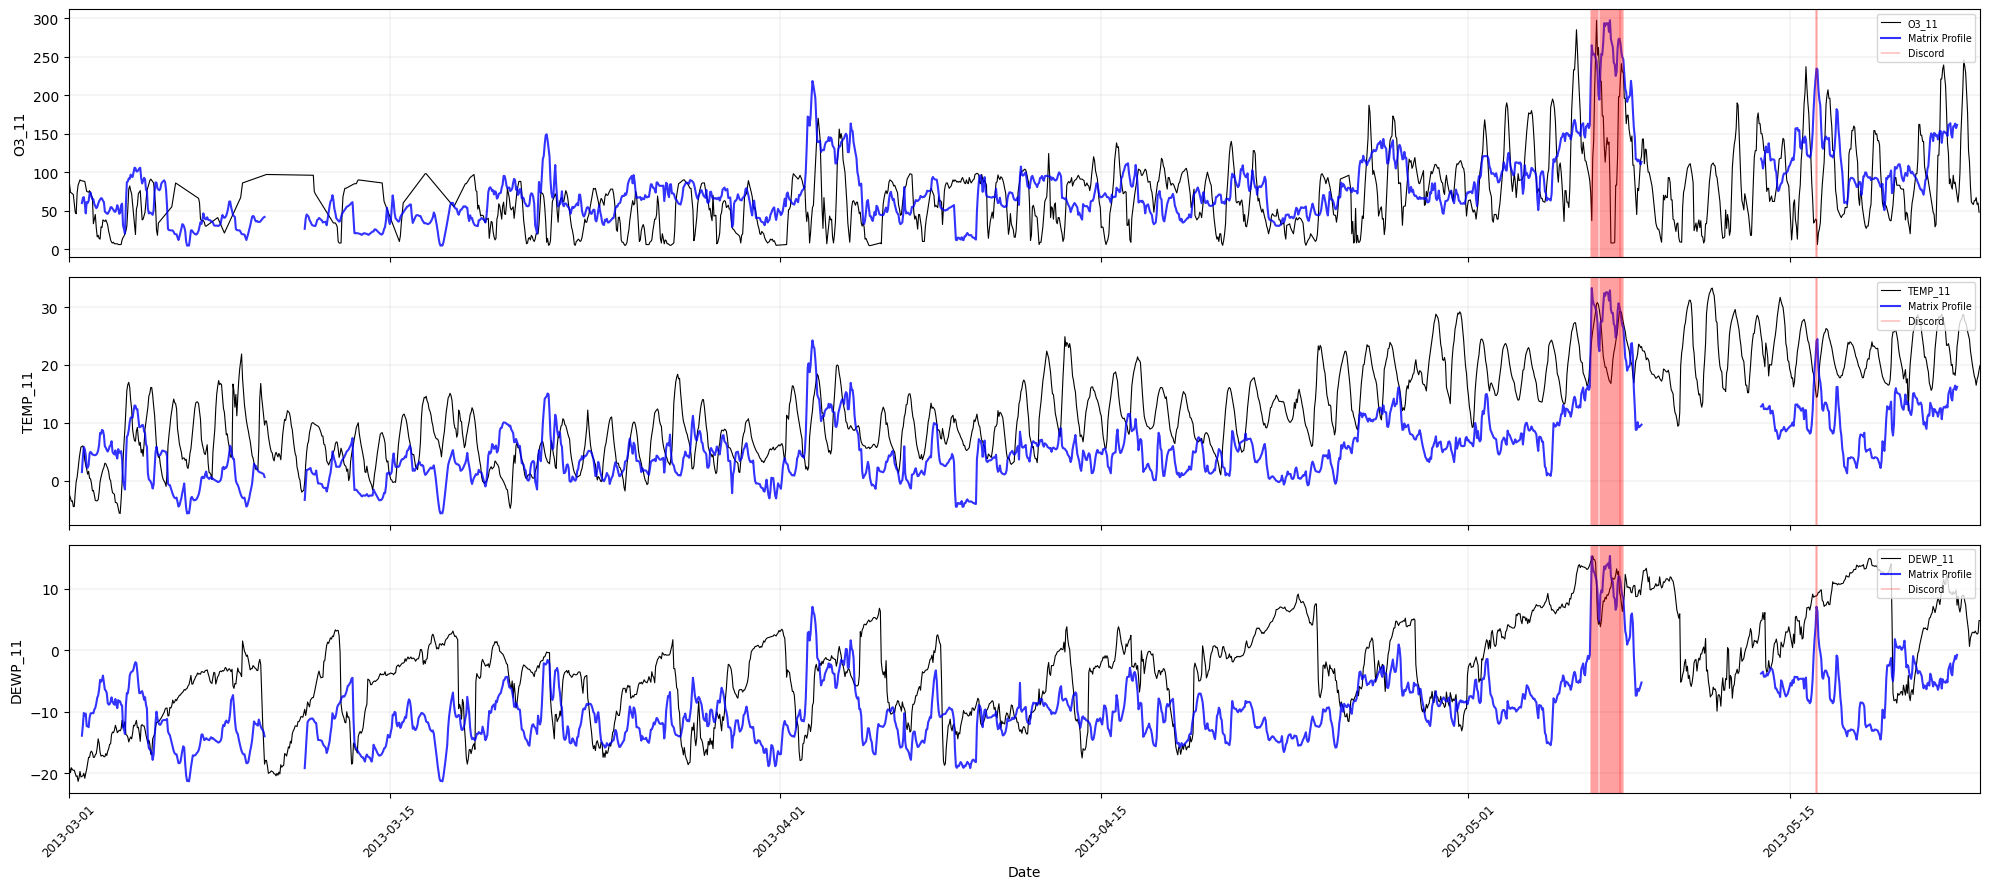

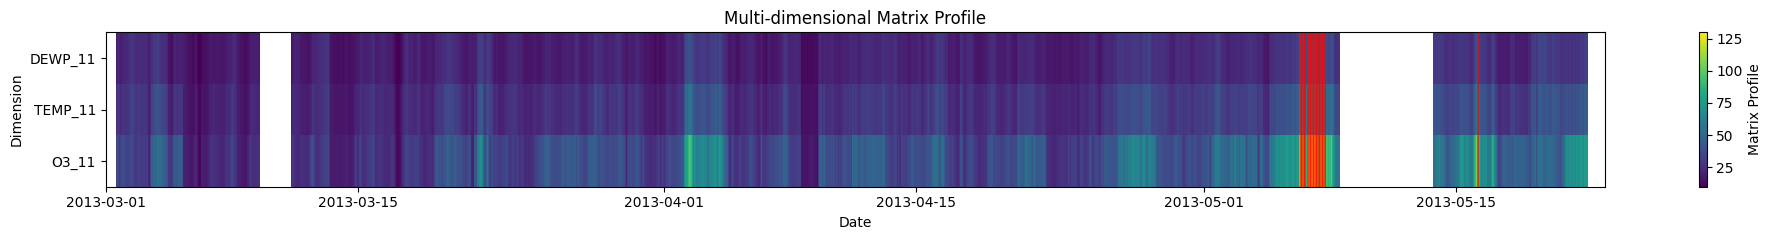


--- Cluster 2 (Window size : 24h) ---


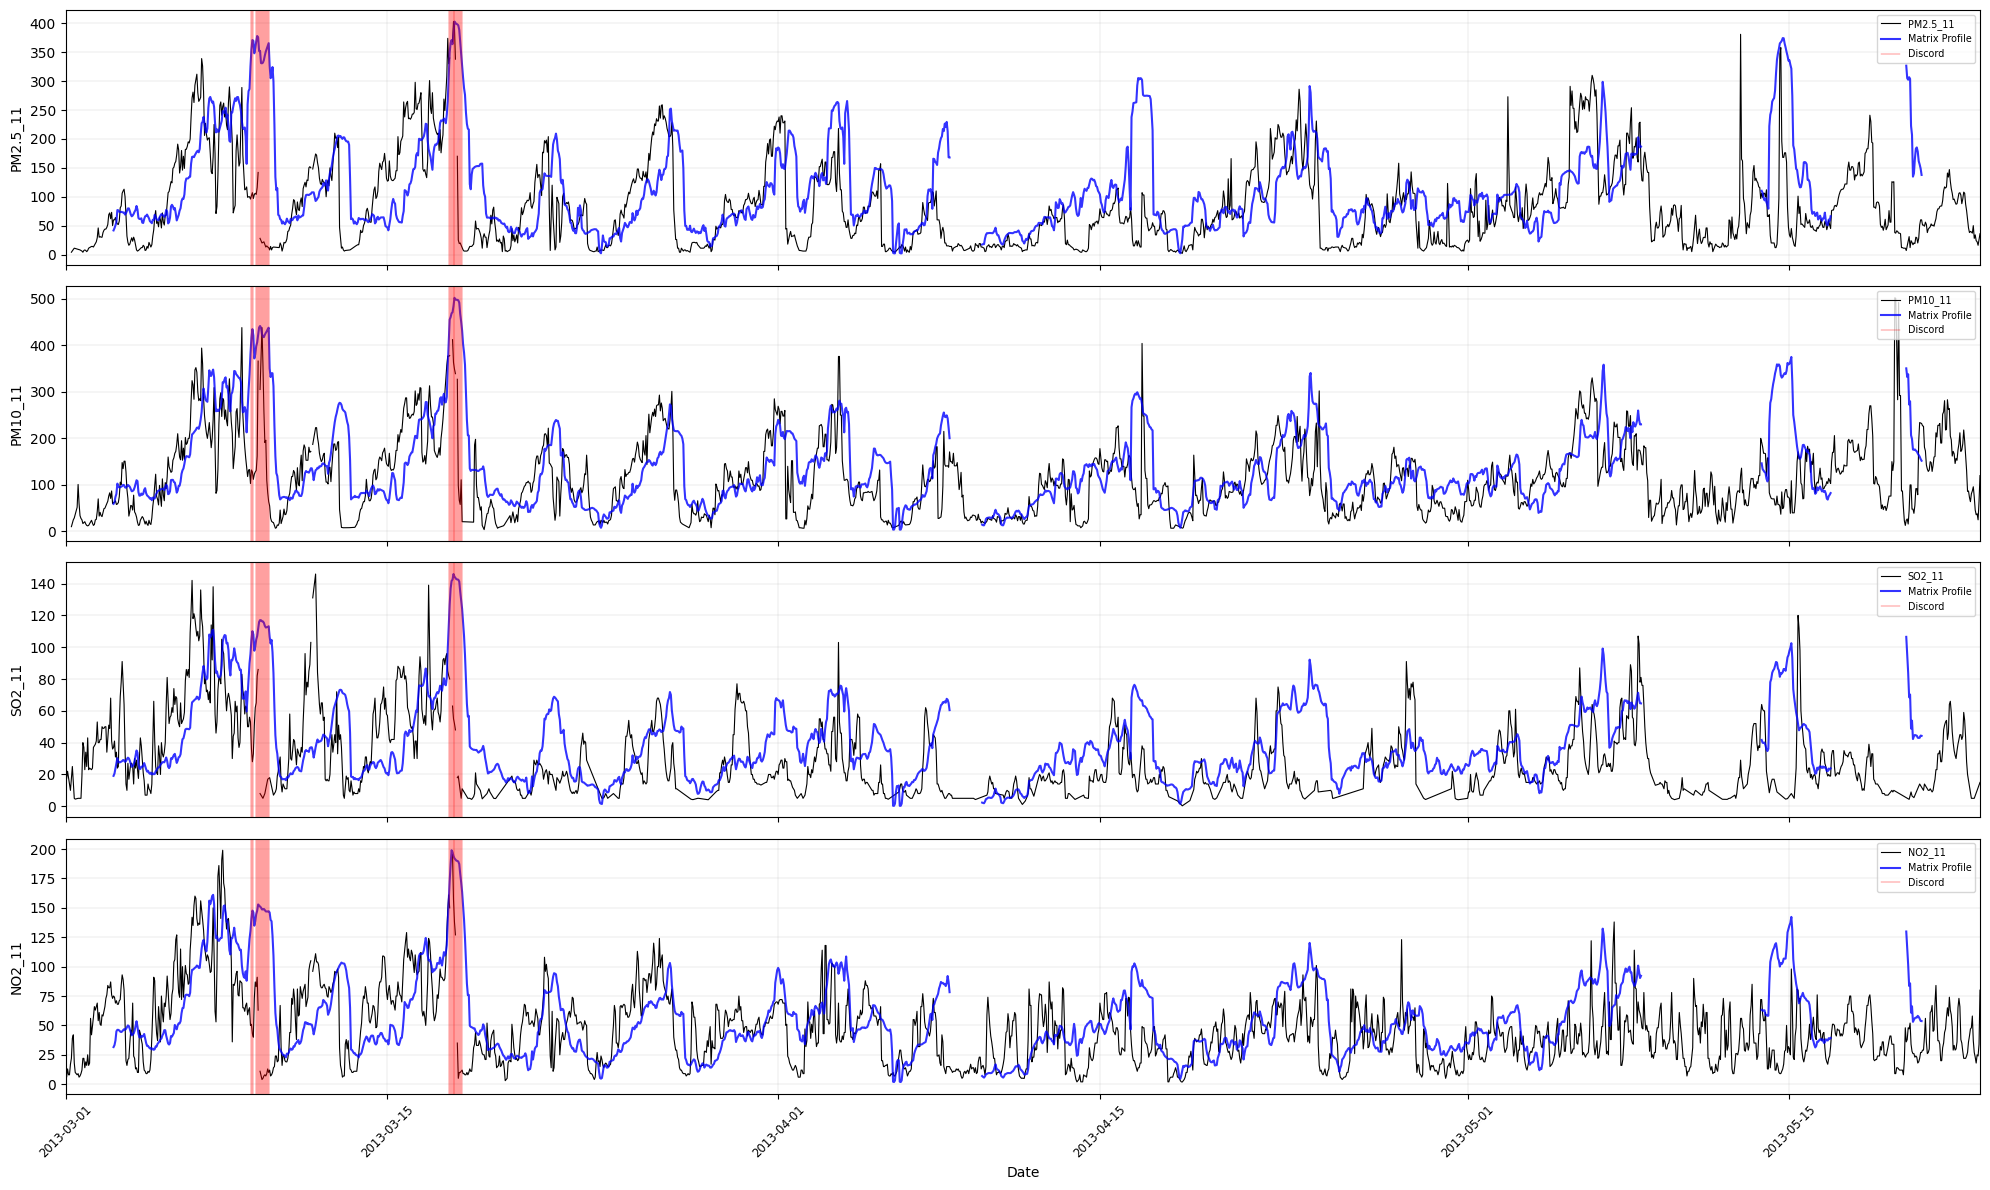

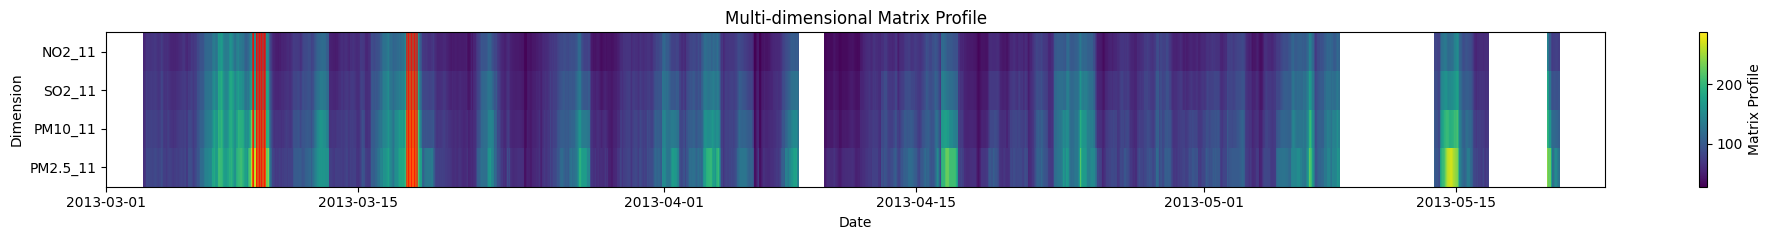

No motifs
No motifs


In [1]:
"""
Notebook - Matrix Profile Analysis using ampiimts (Python 3.11)

Goal:
From preprocessed signals (with original values, normalized values, window_size, clusters),
identify multi dimensional discords and motifs using a fixed-size sliding window based on the matrix profile method (stumpy.mstump).
"""

from ampiimts import ampiimts

folder = '../../dataset/air_bejin'

pds_interpolated, pds_normalized, matrix_profile = ampiimts(folder,
                                                            max_len=2000,
                                                            top_k_cluster=4,
                                                            motif=False, 
                                                            # group_size=16, 
                                                            window_size="24h", 
                                                            display_info=False,
                                                            discord_top_pct=0.02,
                                                            most_stable_only=True,
                                                            )
